A Survey on Technology Choice
======


### Forming a Hypothesis

The variable that I was assigned to is `Familiarity with related packages (PG5_9FRP)`. From the dataset it can be hypothesized that, an individual's priority for this response variable can be influenced by their `age`, `level of experience`, `profession`, `primary programming language`, `first time introduction to the package` and `involvement in software projects`. Next, I am going to build a regression model to test the validity of this hypothesis and then classify the responses based on priorities.

In [ ]:
library(dplyr)
library(tidyr)
library(caret)
library(class)
library(rpart)
library(ape)


In [27]:
# For nicer printing
options(digits=2);

## Data Transformation Statement:
Here I have converted the date to unix second and calculated the time difference using the Start and End time. 
I have left other variables as it is.



In [28]:
# Read in the data
data <- read.csv("TechSurvey - Survey.csv",header=T);

#convert date to unix second
for (i in c("Start", "End")) 
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
for (i in 0:12){
    vnam = paste(c("PG",i,"Submit"), collapse="")
    data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}
#calculate differences in time    
for (i in 12:0){
    pv = paste(c("PG",i-1,"Submit"), collapse="");
    if (i==0) 
        pv="Start";
    vnam = paste(c("PG",i,"Submit"), collapse="");
    data[,vnam] = data[,vnam] -data[,pv];
}

In [29]:
#now explore variables
summary(data);

     Device    Completed       Start                 End            
        :  2   0    :  2   Min.   :1539277149   Min.   :1539278043  
 Bot    :  1   FALSE:546   1st Qu.:1539280872   1st Qu.:1539281035  
 PC     :955   TRUE :805   Median :1539291721   Median :1539290894  
 Phone  :376               Mean   :1539443167   Mean   :1539433642  
 Tablet : 16               3rd Qu.:1539450222   3rd Qu.:1539430091  
 Unknown:  3               Max.   :1540423840   Max.   :1540400566  
                           NA's   :2            NA's   :548         
     PG0Dis       PG0Shown      PG0Submit    
 Min.   :  0   Min.   :   0   Min.   :    2  
 1st Qu.:  0   1st Qu.:   0   1st Qu.:    6  
 Median :  1   Median : 102   Median :    9  
 Mean   : 44   Mean   : 249   Mean   :  299  
 3rd Qu.: 24   3rd Qu.: 428   3rd Qu.:   15  
 Max.   :168   Max.   :1190   Max.   :76226  
 NA's   :73    NA's   :73     NA's   :199    
                                 PG1PsnUse  
 For personal work and/or research 

# Answering Simple Questions

### Time to take entire survey?


In [31]:
total_completed_responses = filter(data, Completed == TRUE)
survey_completion_time = total_completed_responses$End - total_completed_responses$Start
print(paste0("Maximum Time to Complete the Survey: ", max(survey_completion_time), ' seconds'))
print(paste0("Minimum Time to Complete the Survey: ", min(survey_completion_time), ' seconds'))
print(paste0("Average Time to Complete the Survey: ", round(mean(survey_completion_time)), ' seconds'))


[1] "Maximum Time to Complete the Survey: 87551 seconds"
[1] "Minimum Time to Complete the Survey: 51 seconds"
[1] "Average Time to Complete the Survey: 680 seconds"


### Question that took the longest to complete?
### Question that took the least time?


In [32]:
response_completion_time = select(total_completed_responses, contains('Submit')) %>% na.omit()
# print(summary(response_completion_time))
average_completion_time = colMeans(response_completion_time)
print('Average Completion Time:')
print(average_completion_time)


[1] "Average Completion Time:"
 PG0Submit  PG1Submit  PG2Submit  PG3Submit  PG4Submit  PG5Submit  PG6Submit 
     241.5       42.4       31.4       42.5        9.1       85.2       24.5 
 PG7Submit  PG8Submit  PG9Submit PG10Submit PG11Submit PG12Submit 
      10.6       11.6       39.9       16.7        6.4        7.8 


From the above results, it can be inferred that, the 1st question (PG0) took the longest to complete and the 12th question (PG11) took the least time. This can be interpreted as the lack of interest in completing the survey right away.


### Top-ranked criteria?

In [33]:
response_criteria = select(total_completed_responses, starts_with('PG5'), -ends_with('Time'), -ends_with('Order'), -ends_with('Submit')) 
print(summary(response_criteria))


           PG5_1RRPQ             PG5_2BNUI              PG5_3HDS  
                :335                  :381                  :225  
 Essential      : 59   Essential      :  3   Essential      :103  
 High Priority  :102   High Priority  : 25   High Priority  :199  
 Low Priority   : 85   Low Priority   :120   Low Priority   : 68  
 Medium Priority:130   Medium Priority: 91   Medium Priority:161  
 Not a Priority : 94   Not a Priority :185   Not a Priority : 49  
            PG5_4VGP              PG5_5PHR             PG5_6SSYOP 
                :311                  :213                  :310  
 Essential      : 22   Essential      : 79   Essential      : 61  
 High Priority  :109   High Priority  :247   High Priority  :136  
 Low Priority   : 87   Low Priority   : 63   Low Priority   : 83  
 Medium Priority:162   Medium Priority:160   Medium Priority:109  
 Not a Priority :114   Not a Priority : 43   Not a Priority :106  
           PG5_7NDYP              PG5_8CP               PG5_9F

The top-ranked criteria was computing performances (PG5_8CP) with 228 essential categorizations.

### Demographic distribution by age?

                18 - 24     25 - 34     35 - 44     45 - 54     55 - 64 
         42          34         338         258          89          36 
65 and over 
          8 


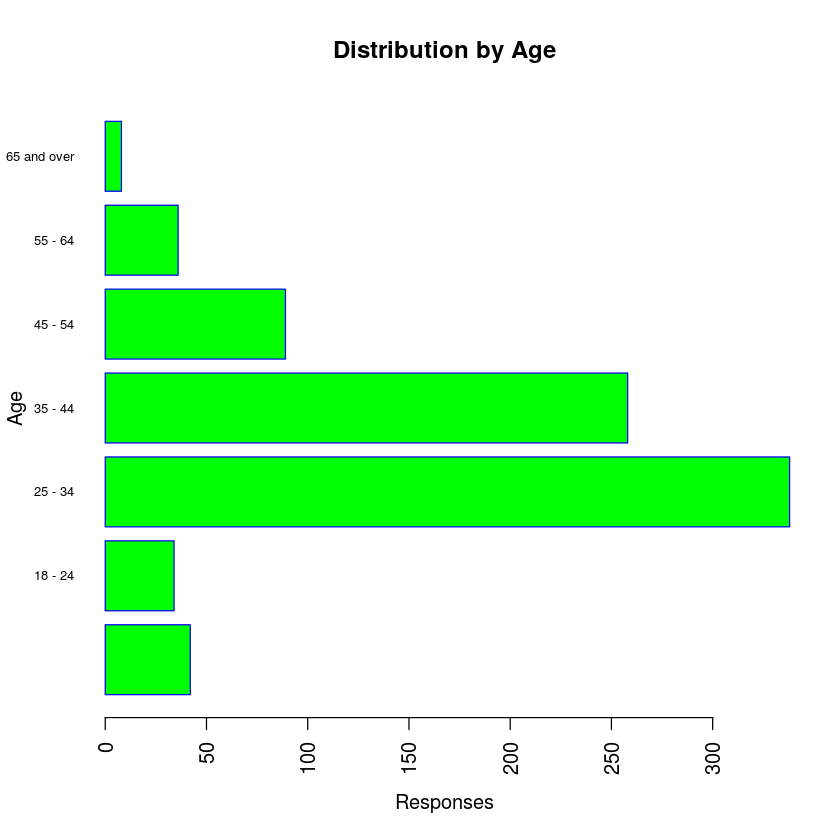

In [34]:
age = total_completed_responses$PG12Resp 
print(summary(age))
barplot(table(age), xlab = 'Responses', ylab = 'Age', main = 'Distribution by Age', border="blue", 
     col="green", horiz=TRUE,
#         mar=c(5,8,4,20),
     las=2,cex.names=0.65)


# Testing My Hypothesis

## Data Cleaning Statement:

### Handle Missing Values:
There some missing values in this dataset which need to be carefully handles to get better results. In this case the missing data are replaced with the mean of the column values. Although R can handle categorical values, I have converted the categorical values into numeric values in order to fill values for missing data. After that I have normalized the column values.

### Correlation Analysis and Dropping Columns:

Here some variables which seem to be overly correlated. To get a better approximation, these variables need to be removed from the dataset. Also, as I was assigned the variable PG5_9FRP, I removed the other PG5 variables.  
Also, from the PCA Analysis I can see that the variables seem to be somewhat independent of one another.

In [37]:
for (i in 1:dim(data)[2]) if (is.factor(data[,i])) data[,i] = as.numeric(data[,i]);
for (i in 1:ncol(data)){
    data[is.na(data[,i]),i] = mean (data[,i],na.rm =TRUE)
}
head (data)

Device,Completed,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1PsnUse,PG1WdAuth,PG1Trn,⋯,PG8Resp,PG8Submit,PG9Resp,PG9Submit,PG10Resp,PG10Submit,PG11Resp,PG11Submit,PG12Resp,PG12Submit
3,2,1539277149,1539433642,44,249,299,1,1,1,⋯,1,12,1,40,1,17,1,6.4,1,7.8
3,2,1539277151,1539433642,44,249,299,1,1,1,⋯,1,12,1,40,1,17,1,6.4,1,7.8
3,3,1539277933,1539278043,44,249,6,4,1,1,⋯,183,12,3,5,2,6,3,3.0,5,4.0
3,2,1539277937,1539433642,44,249,25,4,1,1,⋯,1,12,1,40,1,17,1,6.4,1,7.8
3,3,1539277940,1539278210,44,249,8,4,1,1,⋯,199,19,6,13,2,6,3,4.0,6,5.0
3,2,1539277971,1539433642,44,249,2,1,1,1,⋯,1,12,1,40,1,17,1,6.4,1,7.8


In [38]:
sel = c()
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);

d =data[,sel]

cor(d,method="spearman",use="pairwise.complete.obs"); 


,Device,Completed,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1PsnUse,PG1WdAuth,PG1Trn,⋯,PG8Resp,PG8Submit,PG9Resp,PG9Submit,PG10Resp,PG10Submit,PG11Resp,PG11Submit,PG12Resp,PG12Submit
Device,1.0000,-0.1039,-0.08252,-0.008,0.0058,0.0020,0.0381,-0.039,-0.0586,0.0169,⋯,-0.1070,0.0161,-0.0887,0.13153,-0.0770,0.1349,-0.1059,0.058,-0.114771,0.115
Completed,-0.1039,1.0000,-0.03539,-0.443,-0.0155,0.0120,-0.2515,0.395,0.1398,0.1665,⋯,0.8598,-0.2677,0.8601,-0.82428,0.8783,-0.7599,0.9081,-0.667,0.851797,-0.685
Start,-0.0825,-0.0354,1.00000,0.656,-0.1211,-0.1468,0.1774,-0.063,-0.0940,0.0381,⋯,-0.0155,0.0236,-0.0147,0.04866,-0.0318,0.0542,-0.0392,0.068,-0.009905,0.049
End,-0.0080,-0.4425,0.65555,1.000,-0.0663,-0.1390,0.1608,-0.183,-0.1426,-0.0136,⋯,-0.3748,0.1258,-0.3626,0.38233,-0.3797,0.3702,-0.4103,0.343,-0.353443,0.318
PG0Dis,0.0058,-0.0155,-0.12114,-0.066,1.0000,0.8539,-0.0285,0.051,-0.0061,-0.0256,⋯,-0.0149,0.0474,-0.0070,-0.00026,0.0028,-0.0075,-0.0196,-0.038,-0.014759,0.028
PG0Shown,0.0020,0.0120,-0.14682,-0.139,0.8539,1.0000,-0.0181,0.071,0.0167,-0.0332,⋯,0.0059,0.0350,0.0207,-0.02597,0.0128,-0.0319,0.0082,-0.061,0.000006,0.012
PG0Submit,0.0381,-0.2515,0.17742,0.161,-0.0285,-0.0181,1.0000,-0.282,-0.1000,-0.0463,⋯,-0.1930,0.1453,-0.2432,0.26746,-0.1672,0.2950,-0.2405,0.216,-0.233001,0.222
PG1PsnUse,-0.0386,0.3954,-0.06305,-0.183,0.0511,0.0712,-0.2824,1.000,-0.0490,-0.1746,⋯,0.3164,-0.1271,0.3364,-0.33924,0.3555,-0.2801,0.3816,-0.293,0.312711,-0.289
PG1WdAuth,-0.0586,0.1398,-0.09401,-0.143,-0.0061,0.0167,-0.1000,-0.049,1.0000,-0.0922,⋯,0.1162,-0.0824,0.1430,-0.14512,0.1137,-0.1147,0.1552,-0.093,0.153976,-0.058
PG1Trn,0.0169,0.1665,0.03807,-0.014,-0.0256,-0.0332,-0.0463,-0.175,-0.0922,1.0000,⋯,0.2170,0.0398,0.1444,-0.10679,0.1813,-0.0592,0.1352,-0.047,0.155513,-0.069


In [39]:
hiCor <- function(x, level){
  res <- cor(x, method="spearman");
  res1 <- res; res1[res<0] <- -res[res < 0];
  for (i in 1:dim(x)[2]){
    res1[i,i] <- 0;
  }
  sel <- apply(res1,1,max) > level;
  res[sel,sel];
}
hiCor(d,.7)


,Completed,PG0Dis,PG0Shown,PG2Resp.1,PG5_1RRPQ,PG5_1Time,PG5_2BNUI,PG5_2Time,PG5_3HDS,PG5_3Time,⋯,PG6Resp,PG6Submit,PG7R,PG8Resp,PG9Resp,PG9Submit,PG10Resp,PG10Submit,PG11Resp,PG12Resp
Completed,1.000,-0.01554,0.012007,0.730,0.570,0.5710,0.532,0.5305,0.6683,0.669,⋯,0.875,-0.78,0.8714,0.8598,0.860,-0.82428,0.8783,-0.7599,0.9081,0.851797
PG0Dis,-0.016,1.00000,0.853906,0.025,0.018,-0.0012,0.020,0.0038,0.0015,-0.031,⋯,0.011,0.02,-0.0084,-0.0149,-0.007,-0.00026,0.0028,-0.0075,-0.0196,-0.014759
PG0Shown,0.012,0.85391,1.000000,0.041,0.026,0.0108,0.019,0.0032,-0.0009,-0.039,⋯,0.020,0.01,0.0138,0.0059,0.021,-0.02597,0.0128,-0.0319,0.0082,0.000006
PG2Resp.1,0.730,0.02535,0.041158,1.000,0.416,0.4156,0.386,0.3857,0.4989,0.498,⋯,0.650,-0.56,0.6511,0.6349,0.657,-0.60038,0.6560,-0.5578,0.6794,0.640184
PG5_1RRPQ,0.570,0.01820,0.026343,0.416,1.000,0.9383,0.861,0.8329,0.7069,0.656,⋯,0.513,-0.44,0.5144,0.4926,0.491,-0.47177,0.4857,-0.4510,0.5148,0.468290
PG5_1Time,0.571,-0.00121,0.010757,0.416,0.938,1.0000,0.820,0.8630,0.6905,0.718,⋯,0.519,-0.44,0.5131,0.5051,0.500,-0.46661,0.4944,-0.4206,0.5064,0.469161
PG5_2BNUI,0.532,0.02023,0.019031,0.386,0.861,0.8197,1.000,0.9536,0.7047,0.656,⋯,0.482,-0.42,0.4760,0.4669,0.451,-0.46165,0.4503,-0.4347,0.4907,0.440130
PG5_2Time,0.530,0.00383,0.003206,0.386,0.833,0.8630,0.954,1.0000,0.7003,0.715,⋯,0.486,-0.42,0.4758,0.4673,0.464,-0.45483,0.4548,-0.4161,0.4807,0.441496
PG5_3HDS,0.668,0.00152,-0.000896,0.499,0.707,0.6905,0.705,0.7003,1.0000,0.907,⋯,0.593,-0.51,0.5910,0.5636,0.582,-0.53357,0.5809,-0.5109,0.6211,0.578513
PG5_3Time,0.669,-0.03102,-0.039164,0.498,0.656,0.7180,0.656,0.7153,0.9070,1.000,⋯,0.599,-0.53,0.5821,0.5749,0.592,-0.54147,0.5706,-0.5187,0.6051,0.577441


   
PC1
   
PC2
    Start  End
PC3  0.34 0.39
    PG0Dis PG0Shown PG4AllResp
PC4   0.49      0.5       0.36
    PG0Dis PG0Shown PG4AllResp
PC5   -0.4    -0.42       0.35


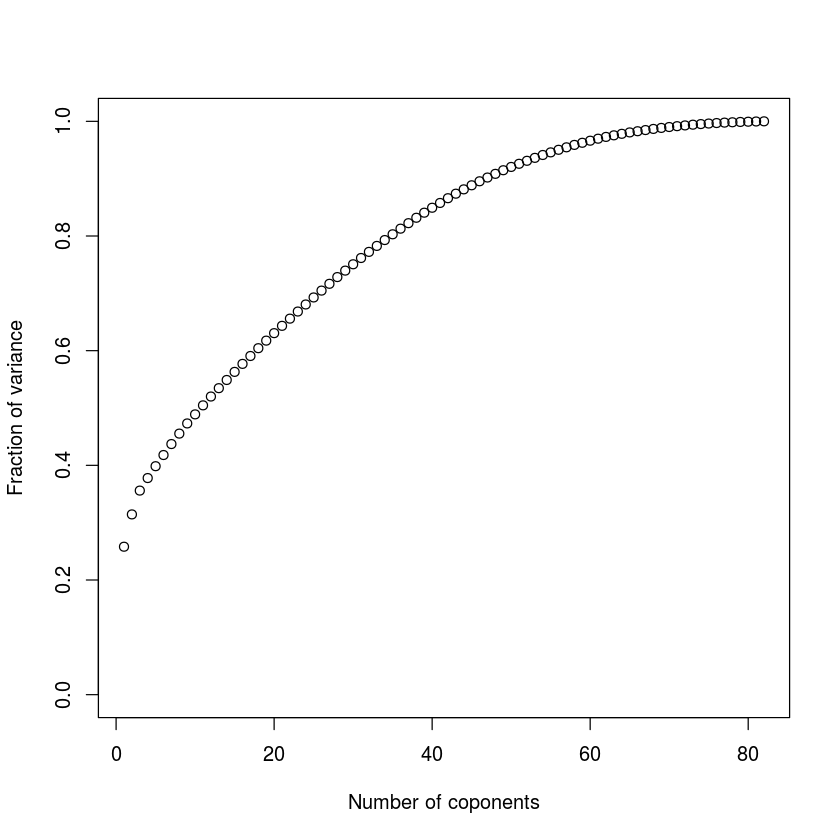

In [40]:
plot(1:dim(d)[2],cumsum(prcomp(d, retx=F,scale=T)$sdev^2)/sum(prcomp(d, retx=F,scale=T)$sdev^2),ylim=c(0,1),xlab="Number of coponents",ylab="Fraction of variance");
res<-prcomp(d, retx=F,scale=T)$rotation[,1:5];
resAbs <- res;
resAbs[res<0] <- -res[res<0];
for (i in 1:5)
  print(t(res[resAbs[,i]>.3,i,drop=FALSE]));


In [41]:
#regress each predictor on the remaining predictors
# eliminate with the highest adjR^2
res <- c();
vnam <- names(d);
for (i in 2:dim(d)[2]){
  fmla <- as.formula(paste(vnam[i],paste(vnam[-c(1,i)],collapse="+"),sep="~"));
  res <- rbind(res,c(i,round(summary(lm(fmla,data=d))$r.squared,2)));
}
row.names(res) <- vnam[res[,1]];
res[order(-res[,2]),];


PG5_12Time,57,0.96
PG5_13Time,60,0.96
PG5_2Time,27,0.95
Completed,2,0.94
PG5_11Time,54,0.94
PG5_7Time,42,0.93
PG5_12NWG,55,0.93
PG5_13NFG,58,0.93
PG5_2BNUI,25,0.92
PG5_11NSG,52,0.92
PG5_4Time,33,0.90


In [42]:
normFunc <- function(x){(x-mean(x, na.rm = T))/sd(x, na.rm = T)}
d[ , names(d) != "PG5_9FRP"] <- apply(d[ , names(d) != "PG5_9FRP"], 2, normFunc)
colnames(data)[grep("PG2Resp.1", colnames(data))] = "PG3Resp"


In [43]:
d[c("Completed","Start", "End","PG5_1RRPQ","PG5_2BNUI","PG5_3HDS","PG5_4VGP","PG5_5PHR","PG5_6SSYOP","PG5_7NDYP","PG5_8CP",
           "PG5_10RPA","PG5_11NSG","PG5_12NWG","PG5_13NFG", "PG5_2Order", "PG5_2Time","PG5_3Order", "PG5_5Order", "PG5_5Time", 
           "PG5_8Time", "PG5_10Order", "PG5_10Time", "PG5_12Order", "PG5_1Order","PG5_1Time", "PG5_3Time", "PG5_4Order",     
           "PG5_4Time", "PG5_6Order", "PG5_6Time", "PG5_7Order", "PG5_7Time", "PG5_8Order","PG5_11Order", 
           "PG5_11Time", "PG5_12Time", "PG5_13Order", "PG5_13Time" )] <- list(NULL)

## Regression Model

Linear regression is used to model linear relationship between an outcome variable, y, and a set of covariates or predictor variables x1,x2,…,xp. To construct a linear regression model in R, I used the lm() function. The model that has been fitted is a regression of the outcome `Familiarity with packages (PG5_9FRP)` against all the other variables in the data set. 


In [44]:
model <- lm(PG5_9FRP ~ ., data = d)

options(scipen=4)  #Set scipen = 0 to get back to default
summary(model)

# library(caret) 
# varImp(model, scale = FALSE)


Call:
lm(formula = PG5_9FRP ~ ., data = d)

Residuals:
   Min     1Q Median     3Q    Max 
-2.623 -0.571 -0.048  0.113  3.850 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.0916482  0.0276405   75.67  < 2e-16 ***
Device         0.0366855  0.0283122    1.30  0.19529    
PG0Dis         0.0272897  0.0368965    0.74  0.45966    
PG0Shown      -0.0180589  0.0368960   -0.49  0.62460    
PG0Submit      0.0045254  0.0280648    0.16  0.87192    
PG1PsnUse     -0.0080235  0.0325154   -0.25  0.80513    
PG1WdAuth      0.0321706  0.0291109    1.11  0.26932    
PG1Trn         0.0213595  0.0315858    0.68  0.49901    
PG1Other      -0.0108306  0.0283285   -0.38  0.70229    
PG1Submit     -0.0328167  0.0280692   -1.17  0.24256    
PG2Resp       -0.0034177  0.0375304   -0.09  0.92745    
PG2Submit     -0.0164711  0.0289387   -0.57  0.56934    
PG2Resp.1      0.1018894  0.0363727    2.80  0.00517 ** 
PG3Submit      0.0296554  0.0282810    1.05  0.29456    
PG

### Validating Hypothesis with Model Interpretation

* `Multiple R-squared`:The R^2 value is a measure of how close our data are to the linear regression model. R^2 values are always between 0 and 1; numbers closer to 1 represent well-fitting models. R^2 always increases as more variables are included in the model, and so adjusted R^2 is included to account for the number of independent variables used to make the model. `In my model`, the `Adjusted R-squared` value is around 52% which is fairly good.

* `F statistic`:This test statistic tells us if there is a relationship between the dependent and independent variables being tested. Generally, a large F indicates a stronger relationship.`In my model`, the `F-static` is 35.7 which is not as large as expected.

* `p-value`: This p-value is associated with the F statistic, and is used to interpret the significance for the whole model fit to our data. `In my model`, by looking at the `p-values`, it looks like PG3Resp, PG5_9Order, PG5_9Time, PG6Resp, PG7R, PG7Submit, PG11Resp are all statistically significant predictors of PG5_9FRP. The coefficients for the predictors PG2Resp.1, PG5_9Order, PG5_9Time, PG6Resp, PG7R, PG7Submit, PG11Resp are all positive, referring that PG5_9FRP is positively associated with them. Therefore, looking at the model summary it can be inferred that the initial hypothesis was somewhat partially true. Other than level of experience, primary programming language and first time introduction to the package; familiarity with packages can be influenced surprisingly by gender and not by age or by profession of the individual. 

* `Degrees of freedom (DoF)`:It is the number of independent pieces of information that were used to calculate an estimate.`In my model`, the DOF are 42 and 1310.

* `Residuals`: Residuals are representing the error between the prediction of the model and the actual results.  Smaller residuals are better.

* `Residual standard error`:This term represents the average amount that the response variable measurements deviate from the fitted linear model (the model error term).

* `Coefficients`: Estimate and Std. Error: Standard errors tell us the average variation of the estimated coefficients from the actual average of our response variable.

* `t value`: This is a test statistic that measures how many standard deviations the estimated coefficient is from zero.


However, there can also be a chance of unreliability in the results due to improper choice of model. Next I have tried to validate the choice of model for the analysis. 




### Validating the model fitness for the data

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”

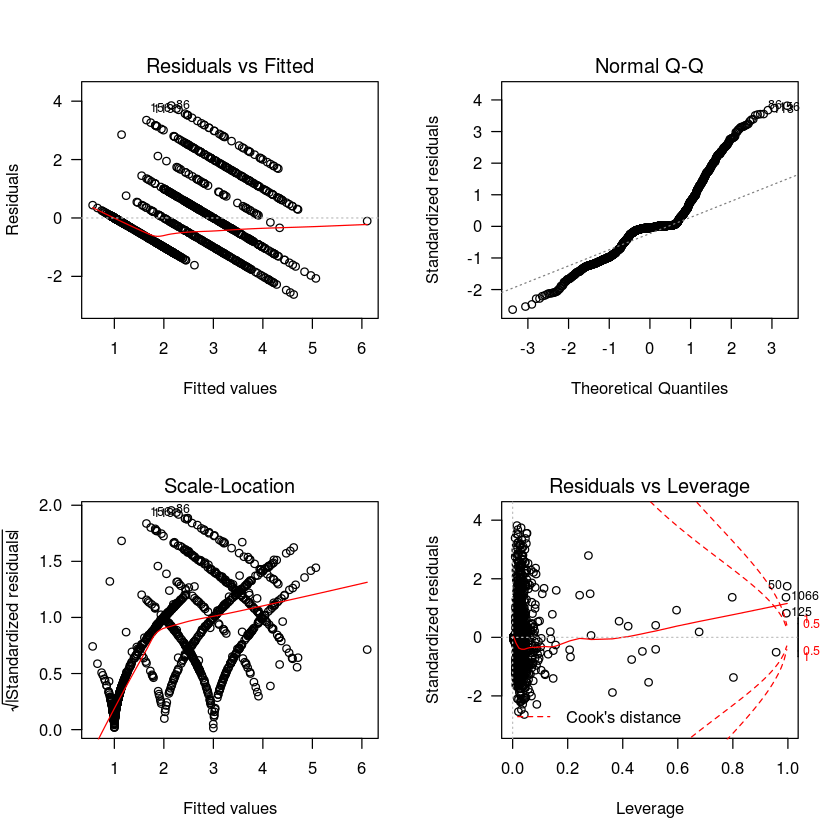

In [45]:
par(mfrow=c(2,2))
plot (model, las=1)


### Model fitness analysis

The above four plots are important diagnostic tools in assessing whether the linear model is appropriate. The first two plots are the most important ones, but the last two can also help with identifying outliers and non-linearities.

* `Residuals vs. Fitted`: To meet the linearity assumptions, the red line should be flat. But here is a clear indication of presence of non-linearity in this plot. Also, there are clear trends in the residual plot indicating that this linear model is inappropriate.

* `Normal QQ plot`: Since to be normally distributed the points on the plot should fall roughly on a diagonal line. In this case, the residuals are looking approximately normally distributed.

* `Scale-location plot`: There should be no discernible trends in this plot. but as it can be seen there is a definite trend in this plot. This increasing trend in residual variance runs through most of the plot. This is indicated by the upward slope of the red line, which can be interpreted as the standard deviation of the residuals at the given level of fitted value.

* `Residuals vs Leverage`: Leverage is a measure of how much an observation influenced the model fit. It’s a one-number summary of how different the model fit would be if the given observation was excluded, compared to the model fit where the observation is included. Points with high residual (poorly described by the model) and high leverage (high influence on model fit) are outliers. They’re skewing the model fit away from the rest of the data, and don’t really seem to fit with the rest of the data. These observations in this case are 50, 125 and 1066.

After analyzing this model's fitness, it can be concluded that there are some potential scopes to improve the model.

## Classification Analysis

Decision trees are applied to situation where data is divided into groups rather than investigating a numerical response and its relationship to a set of descriptor variables. I am going to implement the classification tree here using rpart. I am going to classify the data according to the priority. Here a specific numeric value is assigned to each priority, such as: empty response = 1, Essential = 2, High Priority = 3, Low Priority = 4, Medium Priority = 5 and No Priority = 6. As such, there are 6 classes present in the data.


In [46]:
d[40:50, 18:25]

,PG4Submit,PG5_9FRP,PG5_9Order,PG5_9Time,PG5Submit,PG6Resp,PG6Submit,PG7R
40,-0.033,2,-1.60,-0.65,-0.034,-0.037,-0.075,0.92
41,0.000,1,0.00,-0.72,0.000,-0.951,0.000,-1.08
42,-0.109,2,-0.17,-0.67,-0.152,-0.037,-0.090,0.92
43,-0.335,6,2.34,-0.63,-0.190,-0.037,-0.085,0.92
44,0.270,5,3.06,-0.61,0.153,1.790,-0.085,0.92
45,-0.335,3,-1.24,-0.63,-0.159,-0.037,-0.075,0.92
46,-0.260,5,1.27,-0.64,-0.196,1.333,-0.095,0.92
47,0.000,1,0.00,-0.72,0.000,-0.951,0.000,-1.08
48,0.000,1,0.00,-0.72,0.000,-0.951,0.000,-1.08
49,-0.562,3,-1.60,-0.61,-0.246,-0.037,-0.095,0.92


In [47]:
sample <- floor(0.75 * nrow(d))

set.seed(123)
train <- sample(seq_len(nrow(d)), size = sample)

train_set <- d[train, ]
test_set <- d[-train, ]
tree <- rpart(PG5_9FRP ~ ., data = train_set, method = "class")
print(tree)


n= 1014 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 1014 460 1 (0.55 0.13 0.17 0.032 0.093 0.032)  
    2) PG5_9Time< -0.72 556   0 1 (1 0 0 0 0 0) *
    3) PG5_9Time>=-0.72 458 280 3 (0 0.28 0.38 0.07 0.21 0.07)  
      6) PG5_9Order< -1.1 155  93 2 (0 0.4 0.38 0.077 0.11 0.032)  
       12) Device< 0.38 116  58 2 (0 0.5 0.33 0.06 0.078 0.034)  
         24) PG1Submit>=-0.11 71  28 2 (0 0.61 0.25 0.042 0.07 0.028) *
         25) PG1Submit< -0.11 45  25 3 (0 0.33 0.44 0.089 0.089 0.044) *
       13) Device>=0.38 39  18 3 (0 0.1 0.54 0.13 0.21 0.026) *
      7) PG5_9Order>=-1.1 303 190 3 (0 0.21 0.38 0.066 0.25 0.089)  
       14) PG2Resp.1< -0.85 59  35 2 (0 0.41 0.39 0.034 0.1 0.068)  
         28) PG0Dis>=-0.47 22   9 2 (0 0.59 0.14 0.045 0.18 0.045) *
         29) PG0Dis< -0.47 37  17 3 (0 0.3 0.54 0.027 0.054 0.081) *
       15) PG2Resp.1>=-0.85 244 150 3 (0 0.17 0.37 0.074 0.29 0.094)  
         30) PG2Submit>=-0.35 209 140 3 (0 0.17 0.35 0.086 

In [48]:
printcp(tree) # display the results 


Classification tree:
rpart(formula = PG5_9FRP ~ ., data = train_set, method = "class")

Variables actually used in tree construction:
 [1] Device     PG0Dis     PG12Submit PG1Submit  PG2Resp.1  PG2Submit 
 [7] PG5_9Order PG5_9Time  PG5Submit  PG6Submit  PG7R      

Root node error: 458/1014 = 0

n= 1014 

  CP nsplit rel error xerror xstd
1  0      0         1      1    0
2  0      1         1      1    0
3  0      3         1      1    0
4  0     12         0      1    0


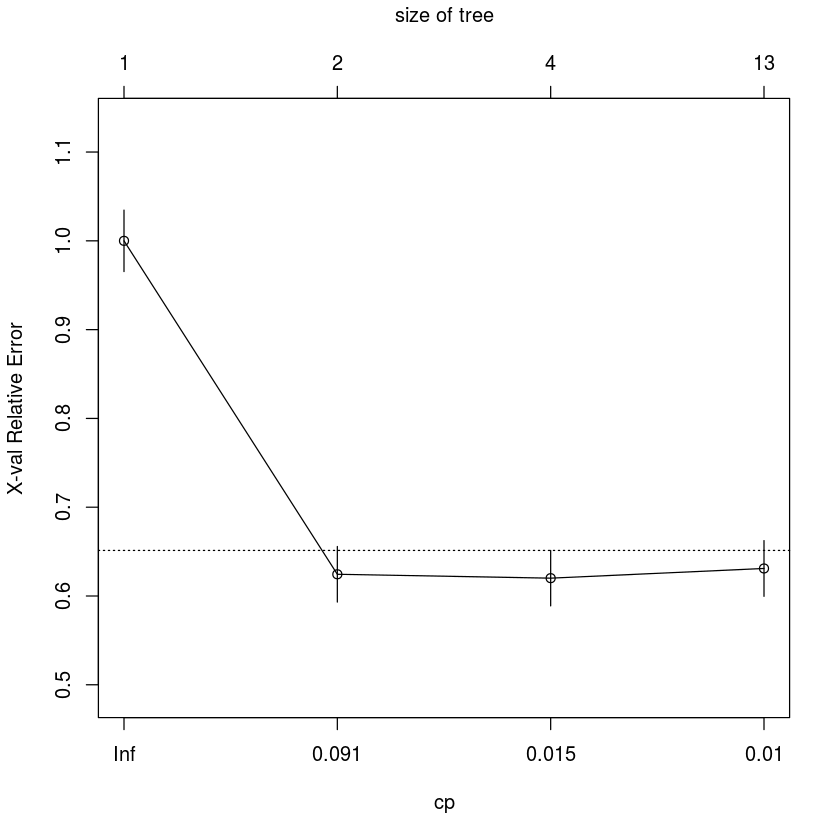

In [49]:
plotcp(tree) # visualize cross-validation results 

In [50]:
summary(tree) # detailed summary of splits

Call:
rpart(formula = PG5_9FRP ~ ., data = train_set, method = "class")
  n= 1014 

     CP nsplit rel error xerror  xstd
1 0.378      0      1.00   1.00 0.035
2 0.022      1      0.62   0.62 0.031
3 0.011      3      0.58   0.62 0.031
4 0.010     12      0.48   0.63 0.031

Variable importance
PG5_9Time   PG6Resp   PG9Resp  PG11Resp  PG10Resp PG9Submit 
       23        15        15        15        15        14 

Node number 1: 1014 observations,    complexity param=0.38
  predicted class=1  expected loss=0.45  P(node) =1
    class counts:   556   127   173    32    94    32
   probabilities: 0.548 0.125 0.171 0.032 0.093 0.032 
  left son=2 (556 obs) right son=3 (458 obs)
  Primary splits:
      PG5_9Time < -0.72  to the left,  improve=320, (0 missing)
      PG6Resp   < -0.72  to the left,  improve=170, (0 missing)
      PG9Resp   < -0.8   to the left,  improve=170, (0 missing)
      PG11Resp  < -0.6   to the left,  improve=160, (0 missing)
      PG10Resp  < -0.43  to the left,  impr

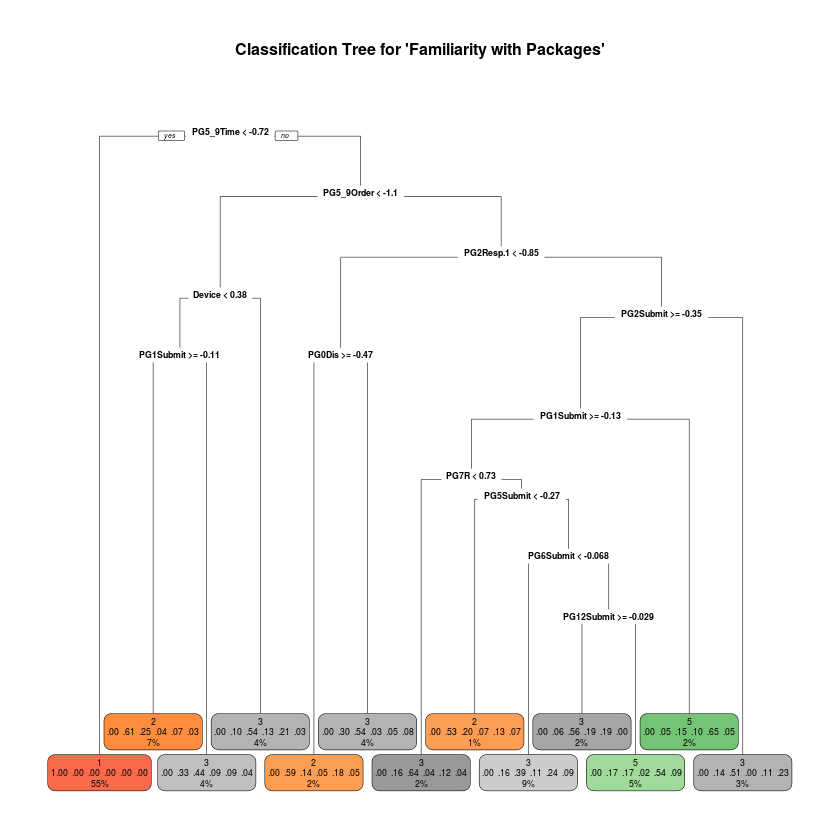

In [51]:
library(rpart.plot)
rpart.plot(tree, type =0, clip.right.lab = FALSE, branch = 1, under = FALSE, 
           main="Classification Tree for 'Familiarity with Packages'")
# text(tree, cex=0.75)

# plot(tree, uniform=TRUE, main="Classification Tree for 'Familiarity with Packages'")


### Interpretation:

This decision tree represents how the priorities for my response variable got affected by other variables of the dataset. Each node is annotated with each variable related to PG5_9FRP. 

### Prediction

In [52]:
pred <- predict(tree,newdata=test_set,type="class");
accuracy <- round(mean(pred == test_set$PG5_9FRP), digits = 4)
print(paste("The model correctly predicted the test outcome ", accuracy*100, "% of the time", sep=""))


[1] "The model correctly predicted the test outcome 70.8% of the time"


# Survey Improvements

The survey can be improved in several ways:
* Question number 5 can be changed to multiple choice questions which would make it easier to respond.
* Some questions can be open to more options; such as profession, purpose of the projects.
* A restriction rule can be added to the survey which would include that if the individual doesn't respond to a question he/she can not move to the next one. In this way there will be less missing data in the dataset and it will be easier for data analysts to analyze the survey data more correctly.